In [ ]:
#!unzip data/data23828/training.zip -d work/
#!unzip data/data23828/valid_gt.zip -d work/
#!unzip data/data23828/validation.zip -d work/

In [ ]:
#!unzip work/PALM-Training400/PALM-Training400.zip -d work/PALM-Training400/

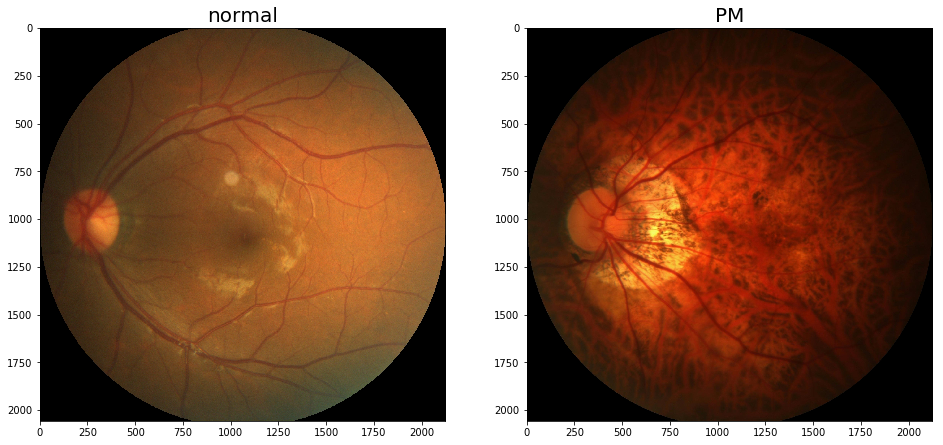

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。用在Jupyter notebook中具体作用是当你调用matplotlib.pyplot的绘图函数plot()进行绘图的时候，或者生成一个figure画布的时候，可以直接在你的python console里面生成图像。
%matplotlib inline
from PIL import Image

DATADIR = 'work/PALM-Training400/PALM-Training400'
# 文件名以N开头的是正常眼底图片，以P开头的是病变眼底图片
file1 = 'N0001.jpg'
file2 = 'P0001.jpg'

# 读取图片
img1 = Image.open(os.path.join(DATADIR, file1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(DATADIR, file2))
img2 = np.array(img2)

# 画出读取的图片
plt.figure(figsize=(16, 8)) # 设置画布
# 位置是由三个整型数值构成，第一个代表行数，第二个代表列数，第三个代表索引位置。举个列子：plt.subplot(2, 3, 5) 和 plt.subplot(235) 是一样一样的。需要注意的是所有的数字不能超过10。
f = plt.subplot(121) 
f.set_title('normal', fontsize=20)
plt.imshow(img1)
f = plt.subplot(122)
f.set_title('PM', fontsize=20)
plt.imshow(img2)
plt.show()

In [12]:
# 查看图片形状
img1.shape, img2.shape

((2056, 2124, 3), (2056, 2124, 3))

In [13]:
import cv2
import random
import numpy as np
import os

# 对读入的图像数据进行预处理
def transform_img(img):
    # 将图片尺寸缩放道 224x224
    img = cv2.resize(img, (224, 224))
    # 读入的图像数据格式是[H, W, C]
    # 使用转置操作将其变成[C, H, W]
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    return img

# 定义训练集数据读取器
def data_loader(datadir, batch_size=10, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # H开头的文件名表示高度近似，N开头的文件名表示正常视力
                # 高度近视和正常视力的样本，都不是病理性的，属于负样本，标签为0
                label = 0
            elif name[0] == 'P':
                # P开头的是病理性近视，属于正样本，标签为1
                label = 1
            else:
                raise('Not excepted file name')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

# 定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    # 训练集读取时通过文件名来确定样本标签，验证集则通过csvfile来读取每个图片对应的标签
    # 请查看解压后的验证集标签数据，观察csvfile文件里面所包含的内容
    # csvfile文件所包含的内容格式如下，每一行代表一个样本，
    # 其中第一列是图片id，第二列是文件名，第三列是图片标签，
    # 第四列和第五列是Fovea的坐标，与分类任务无关
    # ID,imgName,Label,Fovea_X,Fovea_Y
    # 1,V0001.jpg,0,1157.74,1019.87
    # 2,V0002.jpg,1,1285.82,1080.47
    # 打开包含验证集标签的csvfile，并读入其中的内容
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:]:
            line = line.strip().split(',')
            name = line[1]
            label = int(line[2])
            # 根据图片文件名加载图片，并对图像数据作预处理
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

In [14]:
# 查看数据形状
DATADIR = 'work/PALM-Training400/PALM-Training400'
train_loader = data_loader(DATADIR, 
                           batch_size=10, mode='train')
data_reader = train_loader()
data = next(data_reader)
data[0].shape, data[1].shape

eval_loader = data_loader(DATADIR, 
                           batch_size=10, mode='eval')
data_reader = eval_loader()
data = next(data_reader)
data[0].shape, data[1].shape

((10, 3, 224, 224), (10, 1))

In [15]:
import pandas as pd 
import xlrd
import csv
data_xls = pd.read_excel('work/PALM-Validation-GT/PM_Label_and_Fovea_Location.xlsx', index_col=0)
data_xls.to_csv('work/PALM-Validation-GT/PM_Label_and_Fovea_Location.csv', encoding='utf-8')

# import pandas as pd 
# import xlrd
# import csv
# data_xls = pd.read_excel('/home/aistudio/work/PALM-Validation-GT/PM_Label_and_Fovea_Location.xlsx', index_col=0)
# data_xls.to_csv('/home/aistudio/work/PALM-Validation-GT/PM_Label_and_Fovea_Location.csv', encoding='utf-8')

In [16]:
import os
import random
import paddle
import numpy as np

DATADIR = 'work/PALM-Training400/PALM-Training400'
DATADIR2 = 'work/PALM-Validation400'
CSVFILE = 'work/PALM-Validation-GT/PM_Label_and_Fovea_Location.csv'

# 定义训练过程
def train_pm(model, optimizer):
    # 开启0号GPU训练
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    print('start training ... ')
    model.train()
    epoch_num = 5
    # 定义数据读取器，训练数据读取器和验证数据读取器
    train_loader = data_loader(DATADIR, batch_size=10, mode='train')
    valid_loader = valid_data_loader(DATADIR2, CSVFILE)
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = model(img)
            loss = F.binary_cross_entropy_with_logits(logits, label)
            avg_loss = paddle.mean(loss)

            if batch_id % 10 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            # 反向传播，更新权重，清除梯度
            avg_loss.backward()
            optimizer.step()
            optimizer.clear_grad()

        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = model(img)
            # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
            # 计算sigmoid后的预测概率，进行loss计算
            pred = F.sigmoid(logits)
            loss = F.binary_cross_entropy_with_logits(logits, label)
            # 计算预测概率小于0.5的类别
            pred2 = pred * (-1.0) + 1.0
            # 得到两个类别的预测概率，并沿第一个维度级联
            pred = paddle.concat([pred2, pred], axis=1)
            acc = paddle.metric.accuracy(pred, paddle.cast(label, dtype='int64'))

            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
        model.train()

        paddle.save(model.state_dict(), 'palm.pdparams')
        paddle.save(optimizer.state_dict(), 'palm.pdopt')


# 定义评估过程
def evaluation(model, params_file_path):

    # 开启0号GPU预估
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    print('start evaluation .......')

    #加载模型参数
    model_state_dict = paddle.load(params_file_path)
    model.load_dict(model_state_dict)

    model.eval()
    eval_loader = data_loader(DATADIR, 
                        batch_size=10, mode='eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        x_data, y_data = data
        img = paddle.to_tensor(x_data)
        label = paddle.to_tensor(y_data)
        y_data = y_data.astype(np.int64)
        label_64 = paddle.to_tensor(y_data)
        # 计算预测和精度
        prediction, acc = model(img, label_64)
        # 计算损失函数值
        loss = F.binary_cross_entropy_with_logits(prediction, label)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    # 求平均精度
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

ResNet是2015年ImageNet比赛的冠军，将识别错误率降低到了3.6%，这个结果甚至超出了正常人眼识别的精度。

通过前面几个经典模型学习，我们可以发现随着深度学习的不断发展，模型的层数越来越多，网络结构也越来越复杂。那么是否加深网络结构，就一定会得到更好的效果呢？从理论上来说，假设新增加的层都是恒等映射，只要原有的层学出跟原模型一样的参数，那么深模型结构就能达到原模型结构的效果。换句话说，原模型的解只是新模型的解的子空间，在新模型解的空间里应该能找到比原模型解对应的子空间更好的结果。但是实践表明，增加网络的层数之后，训练误差往往不降反升。

Kaiming He等人提出了残差网络ResNet来解决上述问题，其基本思想如 图1所示。

图1(a)：表示增加网络的时候，将xxx映射成y=F(x)y=F(x)y=F(x)输出。
图1(b)：对图1(a)作了改进，输出y=F(x)+xy=F(x) + xy=F(x)+x。这时不是直接学习输出特征yyy的表示，而是学习y−xy-xy−x。
如果想学习出原模型的表示，只需将F(x)F(x)F(x)的参数全部设置为0，则y=xy=xy=x是恒等映射。
F(x)=y−xF(x) = y - xF(x)=y−x也叫做残差项，如果x→yx\rightarrow yx→y的映射接近恒等映射，图1(b)中通过学习残差项也比图1(a)学习完整映射形式更加容易。![](https://ai-studio-static-online.cdn.bcebos.com/a3e04807e366476ba176d99df38af224acdc9a1391b5466b804236e800ac75f1)
图1：残差块设计思想


图1(b)的结构是残差网络的基础，这种结构也叫做残差块（Residual block）。输入xxx通过跨层连接，能更快的向前传播数据，或者向后传播梯度。类似的，由于ResNet每层都存在直连的旁路，相当于每一层都和最终的损失有“直接对话”的机会，自然可以更好的解决梯度弥散的问题。残差块的具体设计方案如 图2 所示，这种设计方案也常称作瓶颈结构（BottleNeck）。1*1的卷积核可以非常方便的调整中间层的通道数，在进入3*3的卷积层之前减少通道数（256->64），经过该卷积层后再恢复通道数(64->256)，可以显著减少网络的参数量。这个结构（256->64->256）像一个中间细，两头粗的瓶颈，所以被称为“BottleNeck”。![](https://ai-studio-static-online.cdn.bcebos.com/96e2112044a845629c5cb91b008d9dac62d6f632070843e7917ec620f1766438)
图2：残差块结构示意图

下图表示出了ResNet-50的结构，一共包含49层卷积和1层全连接，所以被称为ResNet-50。![](https://ai-studio-static-online.cdn.bcebos.com/dd8cecb3b8e943a1b9a2cd1559f384b19c81194590184070bad8453bec8b8dcf)图3：ResNet-50模型网络结构示意图


In [17]:
# ResNet模型代码
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

# ResNet中使用了BatchNorm层，在卷积层的后面加上BatchNorm以提升数值稳定性
# 定义卷积批归一化块
class ConvBNLayer(paddle.nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1,
                 groups=1,
                 act=None):
       
        """
        num_channels, 卷积层的输入通道数
        num_filters, 卷积层的输出通道数
        stride, 卷积层的步幅
        groups, 分组卷积的组数，默认groups=1不使用分组卷积
        """
        super(ConvBNLayer, self).__init__()

        # 创建卷积层
        self._conv = nn.Conv2D(
            in_channels=num_channels,
            out_channels=num_filters,
            kernel_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            bias_attr=False)

        # 创建BatchNorm层
        self._batch_norm = paddle.nn.BatchNorm2D(num_filters)
        
        self.act = act

    def forward(self, inputs):
        y = self._conv(inputs)
        y = self._batch_norm(y)
        if self.act == 'leaky':
            y = F.leaky_relu(x=y, negative_slope=0.1)
        elif self.act == 'relu':
            y = F.relu(x=y)
        return y

# 定义残差块
# 每个残差块会对输入图片做三次卷积，然后跟输入图片进行短接
# 如果残差块中第三次卷积输出特征图的形状与输入不一致，则对输入图片做1x1卷积，将其输出形状调整成一致
class BottleneckBlock(paddle.nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True):
        super(BottleneckBlock, self).__init__()
        # 创建第一个卷积层 1x1
        self.conv0 = ConvBNLayer(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            act='relu')
        # 创建第二个卷积层 3x3
        self.conv1 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        # 创建第三个卷积 1x1，但输出通道数乘以4
        self.conv2 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters * 4,
            filter_size=1,
            act=None)

        # 如果conv2的输出跟此残差块的输入数据形状一致，则shortcut=True
        # 否则shortcut = False，添加1个1x1的卷积作用在输入数据上，使其形状变成跟conv2一致
        if not shortcut:
            self.short = ConvBNLayer(
                num_channels=num_channels,
                num_filters=num_filters * 4,
                filter_size=1,
                stride=stride)

        self.shortcut = shortcut

        self._num_channels_out = num_filters * 4

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)

        # 如果shortcut=True，直接将inputs跟conv2的输出相加
        # 否则需要对inputs进行一次卷积，将形状调整成跟conv2输出一致
        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)

        y = paddle.add(x=short, y=conv2)
        y = F.relu(y)
        return y

# 定义ResNet模型
class ResNet(paddle.nn.Layer):
    def __init__(self, layers=50, class_dim=1):
        """        
        layers, 网络层数，可以是50, 101或者152
        class_dim，分类标签的类别数
        """
        super(ResNet, self).__init__()
        self.layers = layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            #ResNet50包含多个模块，其中第2到第5个模块分别包含3、4、6、3个残差块
            depth = [3, 4, 6, 3]
        elif layers == 101:
            #ResNet101包含多个模块，其中第2到第5个模块分别包含3、4、23、3个残差块
            depth = [3, 4, 23, 3]
        elif layers == 152:
            #ResNet152包含多个模块，其中第2到第5个模块分别包含3、8、36、3个残差块
            depth = [3, 8, 36, 3]
        
        # 残差块中使用到的卷积的输出通道数
        num_filters = [64, 128, 256, 512]

        # ResNet的第一个模块，包含1个7x7卷积，后面跟着1个最大池化层
        self.conv = ConvBNLayer(
            num_channels=3,
            num_filters=64,
            filter_size=7,
            stride=2,
            act='relu')
        self.pool2d_max = nn.MaxPool2D(
            kernel_size=3,
            stride=2,
            padding=1)

        # ResNet的第二到第五个模块c2、c3、c4、c5
        self.bottleneck_block_list = []
        num_channels = 64
        for block in range(len(depth)):
            shortcut = False
            for i in range(depth[block]):
                bottleneck_block = self.add_sublayer(
                    'bb_%d_%d' % (block, i),
                    BottleneckBlock(
                        num_channels=num_channels,
                        num_filters=num_filters[block],
                        stride=2 if i == 0 and block != 0 else 1, # c3、c4、c5将会在第一个残差块使用stride=2；其余所有残差块stride=1
                        shortcut=shortcut))
                num_channels = bottleneck_block._num_channels_out
                self.bottleneck_block_list.append(bottleneck_block)
                shortcut = True

        # 在c5的输出特征图上使用全局池化
        self.pool2d_avg = paddle.nn.AdaptiveAvgPool2D(output_size=1)

        # stdv用来作为全连接层随机初始化参数的方差
        import math
        stdv = 1.0 / math.sqrt(2048 * 1.0)
        
        # 创建全连接层，输出大小为类别数目，经过残差网络的卷积和全局池化后，
        # 卷积特征的维度是[B,2048,1,1]，故最后一层全连接的输入维度是2048
        self.out = nn.Linear(in_features=2048, out_features=class_dim,
                      weight_attr=paddle.ParamAttr(
                          initializer=paddle.nn.initializer.Uniform(-stdv, stdv)))

    def forward(self, inputs):
        y = self.conv(inputs)
        y = self.pool2d_max(y)
        for bottleneck_block in self.bottleneck_block_list:
            y = bottleneck_block(y)
        y = self.pool2d_avg(y)
        y = paddle.reshape(y, [y.shape[0], -1])
        y = self.out(y)
        return y

In [18]:
# 创建模型
model = ResNet()
# 定义优化器
opt = paddle.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameters=model.parameters(), weight_decay=0.001)
# 启动训练过程
train_pm(model, opt)

start training ... 


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


epoch: 0, batch_id: 0, loss is: [0.8667936]
epoch: 0, batch_id: 10, loss is: [0.59041905]
epoch: 0, batch_id: 20, loss is: [0.647819]
epoch: 0, batch_id: 30, loss is: [0.7930282]
